In [1]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=d8ae88c53391e3f22cf04cf68e73b0c80ffec3aa478b81075b9e39a477ffa331
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, month, to_timestamp, when, expr, avg
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import DoubleType
from google.colab import drive
import shutil 
import os
from scipy.stats import f_oneway, ttest_ind
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import pandas as pd
import seaborn as sns

In 2014, the average duration for spring and autumn is affected by the weather conditions

In [3]:
# Set up PySpark
spark = SparkSession.builder.appName("CyclingWeatherAnalysis").getOrCreate()

In [4]:
# URLs of the individual text files
urls = [
    "https://www.metoffice.gov.uk/pub/data/weather/uk/climate/datasets/Tmax/date/England_SE_and_Central_S.txt",
    "https://www.metoffice.gov.uk/pub/data/weather/uk/climate/datasets/Tmin/date/England_SE_and_Central_S.txt",
    "https://www.metoffice.gov.uk/pub/data/weather/uk/climate/datasets/Tmean/date/England_SE_and_Central_S.txt",
    "https://www.metoffice.gov.uk/pub/data/weather/uk/climate/datasets/Rainfall/date/England_SE_and_Central_S.txt",
    "https://www.metoffice.gov.uk/pub/data/weather/uk/climate/datasets/Raindays1mm/date/England_SE_and_Central_S.txt",
    "https://www.metoffice.gov.uk/pub/data/weather/uk/climate/datasets/AirFrost/date/England_SE_and_Central_S.txt",
    "https://www.metoffice.gov.uk/pub/data/weather/uk/climate/datasets/Sunshine/date/England_SE_and_Central_S.txt"
]

column_headers = ['Tmax', 'Tmin', 'Tmean', 'Rainfall', 'Raindays1mm', 'AirFrost', 'Sunshine']

# Create an empty DataFrame to store the data
data = pd.DataFrame()

# Read each text file and extract relevant data for 2014
for url in urls:
    # Read the text file, skipping the header rows
    df = pd.read_csv(url, skiprows=5, delim_whitespace=True)
    # Filter the data for the year 2014
    df = df[df['year'] == 2014]
    # Append the filtered data to the main DataFrame
    data = data.append(df)

# Save the combined data to a CSV file
data.to_csv('weather_data_2014.csv', index=False)
data

<ipython-input-4-cff0a3dff2be>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(df)
<ipython-input-4-cff0a3dff2be>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(df)
<ipython-input-4-cff0a3dff2be>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(df)
<ipython-input-4-cff0a3dff2be>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(df)
<ipython-input-4-cff0a3dff2be>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(df)
<ipython-input-4-cff0a3dff2be>:24: 

,year,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec,win,spr,sum,aut,ann
130,2014,9.4,9.8,12.8,15.0,16.8,20.9,24.0,20.6,20.7,16.7,12.0,8.8,9.67,14.90,21.82,16.46,15.66
130,2014,3.0,3.7,3.3,6.1,8.2,10.6,13.1,11.1,10.8,9.8,6.1,2.2,3.15,5.85,11.62,8.92,7.35
130,2014,6.2,6.7,8.1,10.5,12.5,15.7,18.5,15.8,15.8,13.2,9.0,5.5,6.38,10.37,16.70,12.68,11.49
178,2014,205.4,147.1,38.0,75.2,74.0,37.5,45.7,102.1,13.9,111.0,135.7,53.9,513.8,187.20,185.30,260.60,1039.50
123,2014,23.9,21.4,7.6,11.0,13.8,7.0,7.7,13.5,2.9,16.7,18.4,8.1,62.3,32.40,28.20,38.00,152.00
54,2014,4.5,0.1,4.0,0.3,0.2,0.0,0.0,0.0,0.0,0.0,2.3,11.1,9.3,4.50,0.00,2.30,22.60
104,2014,64.0,97.1,160.2,168.2,202.0,241.7,269.1,199.2,144.6,106.8,58.3,75.0,215.1,530.30,709.90,309.70,1786.10


In [5]:
df = pd.DataFrame(data)

# Transpose the DataFrame to convert rows to columns
df_transposed = df.transpose()

# Set the column names as the first row values
df_transposed.columns = column_headers
# Drop the first row which contains the column names
df_transposed = df_transposed.iloc[1:]

df_transposed = df_transposed[:-5]
# Reset the index
df_transposed['month'] = range(1, 13)

df_transposed

,Tmax,Tmin,Tmean,Rainfall,Raindays1mm,AirFrost,Sunshine,month
jan,9.4,3.0,6.2,205.4,23.9,4.5,64.0,1
feb,9.8,3.7,6.7,147.1,21.4,0.1,97.1,2
mar,12.8,3.3,8.1,38.0,7.6,4.0,160.2,3
apr,15.0,6.1,10.5,75.2,11.0,0.3,168.2,4
may,16.8,8.2,12.5,74.0,13.8,0.2,202.0,5
jun,20.9,10.6,15.7,37.5,7.0,0.0,241.7,6
jul,24.0,13.1,18.5,45.7,7.7,0.0,269.1,7
aug,20.6,11.1,15.8,102.1,13.5,0.0,199.2,8
sep,20.7,10.8,15.8,13.9,2.9,0.0,144.6,9
oct,16.7,9.8,13.2,111.0,16.7,0.0,106.8,10


In [6]:
weather_df = spark.createDataFrame(df_transposed)

In [7]:
# Connect to Google drive to extract csv files from dataset zip file 
drive.mount('/content/drive/')
shutil.unpack_archive("/content/drive/MyDrive/BDA_Datasets/cyclehireusagestats-2014.zip", "/content/Dataset/cycling/")

dataset_path = "/content/Dataset/cycling/"
file_list = os.listdir(dataset_path)
cycling_dataset_files = [os.path.join(dataset_path, file) for file in file_list]

Mounted at /content/drive/


In [8]:
# Create a list of csv file names to iterate over
csv_files = [file for file in cycling_dataset_files if file.endswith('.csv')]
print(csv_files)

# Read and combine the CSV files into a single DataFrame
cycling_df = None
for csv_file in csv_files:
    # Select only first 9 columns in order to avoid garbage columns 
    temp_df = spark.read.option("header", "true").csv(csv_file).select(spark.read.option("header", "true").csv(csv_file).columns[:9])
    # Typecast the duration column to be Double
    temp_df = temp_df.withColumn("Duration", col("Duration").cast(DoubleType()))
    # Drop rows where start date is null 
    temp_df = temp_df.na.drop(subset=["Start Date"])
    # Convert Start Date to timestamp
    temp_df = temp_df.withColumn("Start Date", to_timestamp(col("Start Date"), "dd/MM/yyyy HH:mm"))
    temp_df = temp_df.withColumn("End Date", to_timestamp(col("End Date"), "dd/MM/yyyy HH:mm"))
    # Swap start date and end date if duration is negative
    temp_df = temp_df.withColumn("Swapped Date", when(col("Duration") < 0, col("Start Date")).otherwise(col("End Date")))
    temp_df = temp_df.withColumn("Start Date", when(col("Duration") < 0, col("End Date")).otherwise(col("Start Date")))
    temp_df = temp_df.withColumn("End Date", when(col("Duration") < 0, col("Swapped Date")).otherwise(col("End Date"))).drop("Swapped Date")

     # Calculate duration as the difference between end and start dates
    temp_df = temp_df.withColumn("Duration", expr("(unix_timestamp(`End Date`) - unix_timestamp(`Start Date`))"))

    if cycling_df is None:
        cycling_df = temp_df
    else:
        # Join the temp dataframe with the current dataset 
        cycling_df = cycling_df.union(temp_df)

['/content/Dataset/cycling/9a Journey Data Extract 17Aug14-31Aug14.csv', '/content/Dataset/cycling/1. Journey Data Extract 05Jan14-02Feb14.csv', '/content/Dataset/cycling/10b. Journey Data Extract 28Sep14-11Oct14.csv', '/content/Dataset/cycling/2. Journey Data Extract 03Feb14-01Mar14.csv', '/content/Dataset/cycling/9b Journey Data Extract 01Sep14-13Sep14.csv', '/content/Dataset/cycling/11a. Journey Data Extract 12Oct14-08Nov14.csv', '/content/Dataset/cycling/8a Journey Data Extract 20Jul14-31Jul14.csv', '/content/Dataset/cycling/13a. Journey Data Extract 07Dec14-21Dec14.csv', '/content/Dataset/cycling/7. Journey Data Extract 22Jun14-19Jul14.csv', '/content/Dataset/cycling/6. Journey Data Extract 25May14-21Jun14.csv', '/content/Dataset/cycling/12a. Journey Data Extract 09Nov14-06Dec14.csv', '/content/Dataset/cycling/8b Journey Data Extract 01Aug14-16Aug14.csv', '/content/Dataset/cycling/4. Journey Data Extract 01Apr14-26Apr14.csv', '/content/Dataset/cycling/13b. Journey Data Extract 22D

In [9]:
# Create a month column to join the dataframes 
month_df = cycling_df.withColumn('month', month(cycling_df['Start Date']))
month_df.show()

+---------+--------+-------+-------------------+-------------+--------------------+-------------------+---------------+--------------------+-----+
|Rental Id|Duration|Bike Id|           End Date|EndStation Id|     EndStation Name|         Start Date|StartStation Id|   StartStation Name|month|
+---------+--------+-------+-------------------+-------------+--------------------+-------------------+---------------+--------------------+-----+
| 36389367|     300|   4107|2014-08-17 00:05:00|          206|New Road 1 , Whit...|2014-08-17 00:00:00|            444|Bethnal Green Gar...|    8|
| 36389361|    1140|   3763|2014-08-17 00:19:00|          186|South Wharf Road,...|2014-08-17 00:00:00|            713|Hawley Crescent, ...|    8|
| 36389355|     120|   2284|2014-08-17 00:02:00|          432|Exhibition Road M...|2014-08-17 00:00:00|            428|Exhibition Road, ...|    8|
| 36389352|     360|    446|2014-08-17 00:06:00|          433|Wren Street, Holborn|2014-08-17 00:00:00|            436

In [10]:
# Calculate average durations for each month 
average_duration = month_df.groupBy('month').agg(avg('Duration').alias('Average Duration'))
average_duration.show()

+-----+------------------+
|month|  Average Duration|
+-----+------------------+
|    8|1647.9788206598105|
|    1|1263.6649970286103|
|    2| 1289.442766184877|
|    9|1409.6281749899663|
|   10|1350.7490223738014|
|    3| 1436.769130255284|
|   11| 1270.457242434546|
|    7|1565.2384938097903|
|   12|1434.6541286743106|
|    6|1563.8079027776043|
|    5|1572.9642112057015|
|    4|1525.3704577986489|
+-----+------------------+



In [11]:
weather_df.show()

+----+----+-----+--------+-----------+--------+--------+-----+
|Tmax|Tmin|Tmean|Rainfall|Raindays1mm|AirFrost|Sunshine|month|
+----+----+-----+--------+-----------+--------+--------+-----+
| 9.4| 3.0|  6.2|   205.4|       23.9|     4.5|    64.0|    1|
| 9.8| 3.7|  6.7|   147.1|       21.4|     0.1|    97.1|    2|
|12.8| 3.3|  8.1|    38.0|        7.6|     4.0|   160.2|    3|
|15.0| 6.1| 10.5|    75.2|       11.0|     0.3|   168.2|    4|
|16.8| 8.2| 12.5|    74.0|       13.8|     0.2|   202.0|    5|
|20.9|10.6| 15.7|    37.5|        7.0|     0.0|   241.7|    6|
|24.0|13.1| 18.5|    45.7|        7.7|     0.0|   269.1|    7|
|20.6|11.1| 15.8|   102.1|       13.5|     0.0|   199.2|    8|
|20.7|10.8| 15.8|    13.9|        2.9|     0.0|   144.6|    9|
|16.7| 9.8| 13.2|   111.0|       16.7|     0.0|   106.8|   10|
|12.0| 6.1|  9.0|   135.7|       18.4|     2.3|    58.3|   11|
| 8.8| 2.2|  5.5|    53.9|        8.1|    11.1|    75.0|   12|
+----+----+-----+--------+-----------+--------+--------

In [12]:
# Join the two DataFrames based on the 'month' column
joined_df = weather_df.join(average_duration, 'month', 'inner')

# Show the joined DataFrame
joined_df.show()

+-----+----+----+-----+--------+-----------+--------+--------+------------------+
|month|Tmax|Tmin|Tmean|Rainfall|Raindays1mm|AirFrost|Sunshine|  Average Duration|
+-----+----+----+-----+--------+-----------+--------+--------+------------------+
|    6|20.9|10.6| 15.7|    37.5|        7.0|     0.0|   241.7|1563.8079027776043|
|    5|16.8| 8.2| 12.5|    74.0|       13.8|     0.2|   202.0|1572.9642112057015|
|    1| 9.4| 3.0|  6.2|   205.4|       23.9|     4.5|    64.0|1263.6649970286103|
|    3|12.8| 3.3|  8.1|    38.0|        7.6|     4.0|   160.2| 1436.769130255284|
|    2| 9.8| 3.7|  6.7|   147.1|       21.4|     0.1|    97.1| 1289.442766184877|
|    4|15.0| 6.1| 10.5|    75.2|       11.0|     0.3|   168.2|1525.3704577986489|
|    7|24.0|13.1| 18.5|    45.7|        7.7|     0.0|   269.1|1565.2384938097903|
|    9|20.7|10.8| 15.8|    13.9|        2.9|     0.0|   144.6|1409.6281749899663|
|   10|16.7| 9.8| 13.2|   111.0|       16.7|     0.0|   106.8|1350.7490223738014|
|   12| 8.8| 2.2

In [13]:
joined_df.printSchema()

root
 |-- month: long (nullable = true)
 |-- Tmax: double (nullable = true)
 |-- Tmin: double (nullable = true)
 |-- Tmean: double (nullable = true)
 |-- Rainfall: double (nullable = true)
 |-- Raindays1mm: double (nullable = true)
 |-- AirFrost: double (nullable = true)
 |-- Sunshine: double (nullable = true)
 |-- Average Duration: double (nullable = true)



In [14]:
# Perform exploratory data analysis (EDA) to gain insights
joined_df.describe().show()

+-------+-----------------+-----------------+------------------+------------------+------------------+-----------------+----------------+-----------------+------------------+
|summary|            month|             Tmax|              Tmin|             Tmean|          Rainfall|      Raindays1mm|        AirFrost|         Sunshine|  Average Duration|
+-------+-----------------+-----------------+------------------+------------------+------------------+-----------------+----------------+-----------------+------------------+
|  count|               12|               12|                12|                12|                12|               12|              12|               12|                12|
|   mean|              6.5|           15.625| 7.333333333333332|11.458333333333334|            86.625|12.66666666666667|           1.875|           148.85|1444.2271123494127|
| stddev|3.605551275463989|5.150308905122277|3.7490200739862023| 4.404844096577257|55.684976348285275|6.431786593776164|3.339

In [15]:
# Convert to a pandas DataFrame
pd_joined_df = joined_df.toPandas()

In [16]:
# Define a function to map months to seasons
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'

# Apply the function to create a new column 'Season'
pd_joined_df['Season'] = pd_joined_df['month'].apply(get_season)

In [17]:
pd_joined_df

,month,Tmax,Tmin,Tmean,Rainfall,Raindays1mm,AirFrost,Sunshine,Average Duration,Season
0,6,20.9,10.6,15.7,37.5,7.0,0.0,241.7,1563.807903,Summer
1,5,16.8,8.2,12.5,74.0,13.8,0.2,202.0,1572.964211,Spring
2,1,9.4,3.0,6.2,205.4,23.9,4.5,64.0,1263.664997,Winter
3,3,12.8,3.3,8.1,38.0,7.6,4.0,160.2,1436.769130,Spring
4,2,9.8,3.7,6.7,147.1,21.4,0.1,97.1,1289.442766,Winter
5,4,15.0,6.1,10.5,75.2,11.0,0.3,168.2,1525.370458,Spring
6,7,24.0,13.1,18.5,45.7,7.7,0.0,269.1,1565.238494,Summer
7,9,20.7,10.8,15.8,13.9,2.9,0.0,144.6,1409.628175,Autumn
8,10,16.7,9.8,13.2,111.0,16.7,0.0,106.8,1350.749022,Autumn
9,12,8.8,2.2,5.5,53.9,8.1,11.1,75.0,1434.654129,Winter


Null Hypothesis (H0): The average duration of bike rides in Autumn is not correlated with weather conditions.

Alternative Hypothesis (H1): The average duration of bike rides in Autumn is correlated with weather conditions.

In [18]:
from scipy.stats import pearsonr

# Extract the average duration of bike rides and weather variables for Autumn in 2014
autumn_duration = pd_joined_df.loc[pd_joined_df['Season'] == 'Autumn', 'Average Duration']
autumn_weather_variables = pd_joined_df.loc[pd_joined_df['Season'] == 'Autumn', ['Tmax', 'Tmin', 'Rainfall', 'Sunshine']]

# Compute the correlation coefficients and p-values
correlations = {}
p_values = {}
for column in autumn_weather_variables.columns:
    correlation, p_value = pearsonr(autumn_duration, autumn_weather_variables[column])
    correlations[column] = correlation
    p_values[column] = p_value

# Print the results
print("Correlation Analysis Results for Autumn:")
for column in autumn_weather_variables.columns:
    print(f"Variable: {column}")
    print(f"Pearson's Correlation Coefficient: {correlations[column]}")
    print(f"P-Value: {p_values[column]}")

Correlation Analysis Results for Autumn:
Variable: Tmax
Pearson's Correlation Coefficient: 0.999110657506806
P-Value: 0.026851084681373455
Variable: Tmin
Pearson's Correlation Coefficient: 0.9732878744612584
P-Value: 0.1474758330090578
Variable: Rainfall
Pearson's Correlation Coefficient: -0.9134189088241944
P-Value: 0.2668646703450724
Variable: Sunshine
Pearson's Correlation Coefficient: 0.9998531793817189
P-Value: 0.010909226502294353


Based on the correlation analysis results for Autumn:

*   Tmax (maximum temperature) has a strong positive correlation with the average duration of bike rides (Pearson's correlation coefficient = 0.999), and the p-value (0.027) suggests that this correlation is statistically significant.
*   Tmin (minimum temperature) also has a strong positive correlation with the average duration of bike rides (Pearson's correlation coefficient = 0.973), but the p-value (0.147) is relatively high, indicating that the correlation may not be statistically significant.
*   Rainfall has a negative correlation with the average duration of bike rides (Pearson's correlation coefficient = -0.913), but the p-value (0.267) is high, suggesting that this correlation is not statistically significant.
*   Sunshine has a very strong positive correlation with the average duration of bike rides (Pearson's correlation coefficient = 0.999), and the low p-value (0.011) indicates that this correlation is statistically significant.







In [19]:
# Extract the average duration of bike rides and weather variables for Autumn in 2014
spring_duration = pd_joined_df.loc[pd_joined_df['Season'] == 'Spring', 'Average Duration']
spring_weather_variables = pd_joined_df.loc[pd_joined_df['Season'] == 'Spring', ['Tmax', 'Tmin', 'Rainfall', 'Sunshine']]

# Compute the correlation coefficients and p-values
correlations = {}
p_values = {}
for column in spring_weather_variables.columns:
    correlation, p_value = pearsonr(spring_duration, spring_weather_variables[column])
    correlations[column] = correlation
    p_values[column] = p_value

# Print the results
print("Correlation Analysis Results for Spring:")
for column in autumn_weather_variables.columns:
    print(f"Variable: {column}")
    print(f"Pearson's Correlation Coefficient: {correlations[column]}")
    print(f"P-Value: {p_values[column]}")

Correlation Analysis Results for Spring:
Variable: Tmax
Pearson's Correlation Coefficient: 0.9934582101965455
P-Value: 0.07285853816518667
Variable: Tmin
Pearson's Correlation Coefficient: 0.9959684836656958
P-Value: 0.0571841073452716
Variable: Rainfall
Pearson's Correlation Coefficient: 0.9287134054453303
P-Value: 0.24183179481206618
Variable: Sunshine
Pearson's Correlation Coefficient: 0.8705674613519679
P-Value: 0.327503897039769


Based on the correlation analysis results for Spring: 
 

*   Tmax (maximum temperature) has a strong positive correlation with the average duration of bike rides (Pearson's correlation coefficient = 0.993), but the p-value (0.073) is relatively high, indicating that the correlation may not be statistically significant.
*   Tmin (minimum temperature) also has a strong positive correlation with the average duration of bike rides (Pearson's correlation coefficient = 0.996), but the p-value (0.057) is relatively high, suggesting that the correlation may not be statistically significant.
*   Rainfall has a positive correlation with the average duration of bike rides (Pearson's correlation coefficient = 0.929), but the p-value (0.242) is high, indicating that this correlation is not statistically significant.
*   Sunshine has a positive correlation with the average duration of bike rides (Pearson's correlation coefficient = 0.871), but the p-value (0.328) is high, suggesting that this correlation is not statistically significant.

Overall, in both Autumn and Spring, Tmax and Sunshine show strong positive correlations with the average duration of bike rides. However, the statistical significance of these correlations varies between the two seasons. Further analysis and interpretation are needed to determine the practical implications of these correlations and their relationship with the first hypothesis regarding longer bike rides in Autumn compared to Spring.

In [20]:
# Split the dataset into Spring and Weather dataframes
spring_df = pd_joined_df[pd_joined_df['Season'] == 'Spring']
autumn_df = pd_joined_df[pd_joined_df['Season'] == 'Autumn']

In [21]:
spring_df

,month,Tmax,Tmin,Tmean,Rainfall,Raindays1mm,AirFrost,Sunshine,Average Duration,Season
1,5,16.8,8.2,12.5,74.0,13.8,0.2,202.0,1572.964211,Spring
3,3,12.8,3.3,8.1,38.0,7.6,4.0,160.2,1436.769130,Spring
5,4,15.0,6.1,10.5,75.2,11.0,0.3,168.2,1525.370458,Spring


In [22]:
autumn_df

,month,Tmax,Tmin,Tmean,Rainfall,Raindays1mm,AirFrost,Sunshine,Average Duration,Season
7,9,20.7,10.8,15.8,13.9,2.9,0.0,144.6,1409.628175,Autumn
8,10,16.7,9.8,13.2,111.0,16.7,0.0,106.8,1350.749022,Autumn
11,11,12.0,6.1,9.0,135.7,18.4,2.3,58.3,1270.457242,Autumn


In [23]:
spring_corr = spring_df.loc[spring_df['Season'] == 'Spring', 'Sunshine'].corr(spring_df.loc[spring_df['Season'] == 'Spring', 'Average Duration'])
spring_p_value = spring_df.loc[spring_df['Season'] == 'Spring', 'Sunshine'].corr(spring_df.loc[spring_df['Season'] == 'Spring', 'Average Duration'])

autumn_corr = autumn_df.loc[autumn_df['Season'] == 'Autumn', 'Sunshine'].corr(autumn_df.loc[autumn_df['Season'] == 'Autumn', 'Average Duration'])
autumn_p_value = autumn_df.loc[autumn_df['Season'] == 'Autumn', 'Sunshine'].corr(autumn_df.loc[autumn_df['Season'] == 'Autumn', 'Average Duration'])

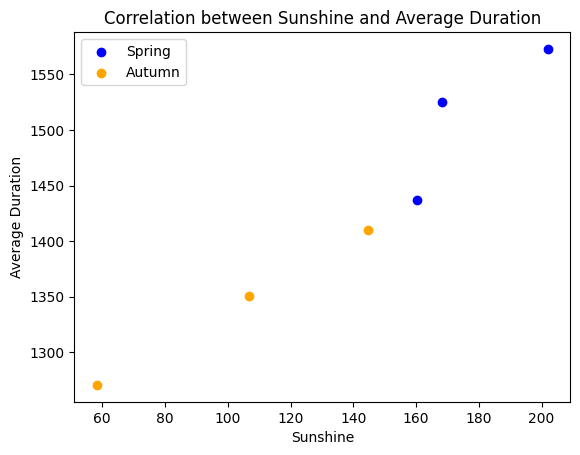

In [24]:
# Scatter plot for Spring
plt.scatter(spring_df.loc[spring_df['Season'] == 'Spring', 'Sunshine'], spring_df.loc[spring_df['Season'] == 'Spring', 'Average Duration'], color='blue', label='Spring')

# Scatter plot for Autumn
plt.scatter(autumn_df.loc[autumn_df['Season'] == 'Autumn', 'Sunshine'], autumn_df.loc[autumn_df['Season'] == 'Autumn', 'Average Duration'], color='orange', label='Autumn')

plt.xlabel('Sunshine')
plt.ylabel('Average Duration')
plt.title('Correlation between Sunshine and Average Duration')
plt.legend()
plt.show()

Based on the positive correlation relationship between the amount of sunshine and the average duration of bike rides during autumn and spring, we can refine the hypothesis as follows:

Null Hypothesis (H0): The average duration of bike rides in Autumn is not affected by the amount of sunshine.

Alternative Hypothesis (H1): The average duration of bike rides in Autumn is higher due to the amount of sunshine.

In [25]:
spring_durations = spring_df['Average Duration'].tolist()
autumn_durations = autumn_df['Average Duration'].tolist()

# Perform a two-sample independent t-test

t_stat, p_value = ttest_ind(spring_durations, autumn_durations)

print("T-Statistic:", t_stat)
print("P-Value:", p_value)

T-Statistic: 2.9625374367447637
P-Value: 0.041449913847478134


In [26]:
# Compare the p-value to the significance level (e.g., α = 0.05) to make a conclusion
significance_level = 0.05
if p_value < significance_level:
    conclusion = "Reject the null hypothesis. There is a significant difference in the impact of sunshine on bike ride duration between Spring and Autumn."
else:
    conclusion = "Fail to reject the null hypothesis. There is no significant difference in the impact of sunshine between Spring and Autumn."
conclusion 

'Reject the null hypothesis. There is a significant difference in the impact of sunshine on bike ride duration between Spring and Autumn.'

### Based on the t-test result, we can conclude that the amount of sunlight impacts the average duration for bike rides in Autumn and Spring. Since the amount of sunlight in Autumn is less compared to Spring, this directly affects the bike ride duration. 